# MS011 Preprocess
01/25/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS011'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [63]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/raw/MS011_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3231999  =      0.000 ...  3156.249 secs...


In [64]:
mne_data

<RawEDF | MS011_SWB.edf, 276 x 3232000 (3156.2 s), ~6.65 GB, data loaded>

In [65]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'RmOlF11',
 'RmOlF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'LmCpS1',
 'LmCpS2',
 'LmCpS3',
 'LmCpS4',
 'LmCpS5',
 'LmCpS6',
 'LmCpS7',
 'LmCpS8',
 'LmCpS9',
 'LmCpS10',
 'RmCpS1',
 'RmCpS2',
 'RmCpS3',
 'RmCpS4',
 'RmCpS5',
 'RmCpS6',
 'RmCpS7',
 'RmCpS8',
 'RmCpS9',
 'RmCpS10',
 'C63',
 'C64',
 'LasEnc1',
 'LasEnc2',
 'LasEnc3',
 'LasEnc4',
 'LasEnc5',
 'LasEnc6',
 'LasEnc7',
 'LasEnc8',
 'R Ins1',
 'R lns2',
 'R lns3',
 'R lns4',
 'R lns5',
 'R lns6',
 'R lns7',
 'R lns8',
 'R lns9',
 'R lncs10',
 'R lns11',
 'R lns12',
 'R lns13',
 'R lns14',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAg

<IPython.core.display.Javascript object>


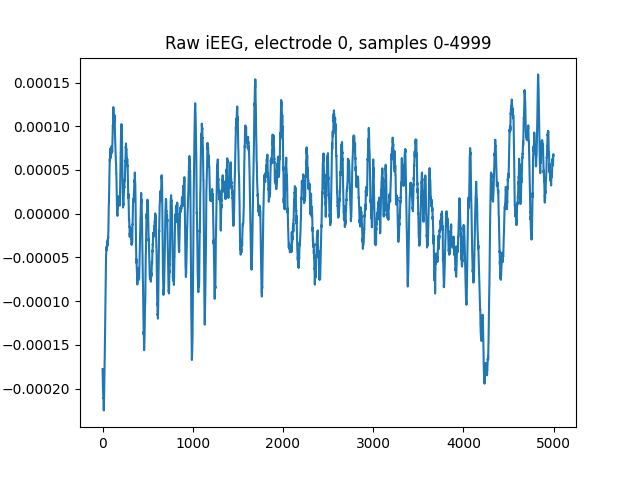

In [66]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [67]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   50.5s finished


<RawEDF | MS011_SWB.edf, 276 x 1578125 (3156.2 s), ~3.25 GB, data loaded>

### Photodiode
- examine photodiode 

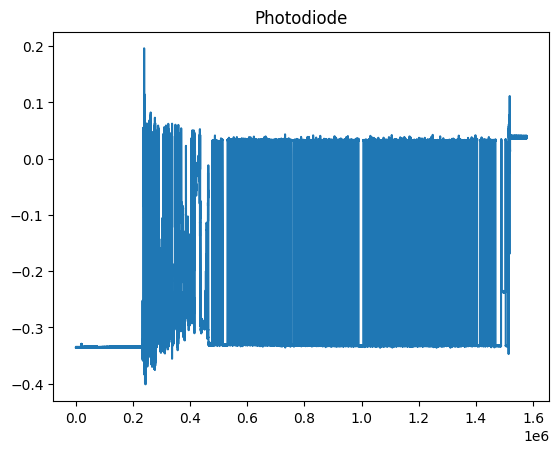

In [11]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Research")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [68]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Research', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/photodiode.fif
[done]


In [69]:
mne_data.drop_channels(['Research'])

<RawEDF | MS011_SWB.edf, 275 x 1578125 (3156.2 s), ~3.23 GB, data loaded>

### Notch filter line noise

In [102]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    9.6s finished


<RawEDF | MS011_SWB.edf, 136 x 1578125 (3156.2 s), ~1.60 GB, data loaded>

### Anatomical Localization

In [70]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS011_SWB.edf, 275 x 1578125 (3156.2 s), ~3.23 GB, data loaded>

In [71]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0    LaCas1    Unknown -12.131612  38.516561   2.948285 -15.405845  29.575167   
1    LaCas2    Unknown -13.329267  40.514536   7.745699 -16.450350  32.421977   
2    LaCas3    Unknown -14.526922  42.112916  12.143328 -17.566868  34.795708   
3    LaCas4    Unknown -15.724576  44.110891  16.540958 -18.597276  37.555895   
4    LaCas5    Unknown -16.922231  46.108866  21.338372 -19.583705  40.416454   
..      ...        ...        ...        ...        ...        ...        ...   
131  RmTpT5    Unknown  50.146427 -29.414582  -8.245681  44.272789 -45.383760   
132  RmTpT6    Unknown  54.537827 -31.812152  -8.245681  48.484943 -48.102177   
133  RmTpT7    A37dl_R  58.929228 -34.209722  -8.245681  52.750059 -50.933108   
134  RmTpT8    A37dl_R  63.320628 -36.607292  -7.845897  57.081094 -53.742142   
135  RmTpT9    A37dl_R  66.913592 -37.806077  -8.245681  60.707620 -55.409753   

         mni_z     gm                              NMM     Anat  \
0    -6.324023  White       Left Cerebral White Matter  Unknown   
1    -1.117910  White       Left Cerebral White Matter  Unknown   
2     3.729886  White       Left Cerebral White Matter  Unknown   
3     8.520236  White       Left Cerebral White Matter  Unknown   
4    13.790957  White       Left Cerebral White Matter  Unknown   
..         ...    ...                              ...      ...   
131  -5.613669  White      Right Cerebral White Matter  Unknown   
132  -4.833832  White      Right Cerebral White Matter  Unknown   
133  -4.156334   Gray  Right MTG middle temporal gyrus  Unknown   
134  -3.024693   Gray  Right MTG middle temporal gyrus  Unknown   
135  -3.109425   Gray  Right MTG middle temporal gyrus  Unknown   

                     AnatMacro    BN246  \
0                      Unknown  Unknown   
1                      Unknown  Unknown   
2                      Unknown  Unknown   
3                      Unknown  Unknown   
4                      Unknown  Unknown   
..                         ...      ...   
131                    Unknown  Unknown   
132  R Inferior Temporal Gyrus  Unknown   
133  R Inferior Temporal Gyrus    R MTG   
134  R Inferior Temporal Gyrus    R MTG   
135  R Inferior Temporal Gyrus    R MTG   

                                      YBA_1      Manual Examination Notes  
0                                   Unknown  Left cingulate gyrus C   NaN  
1                                   Unknown                      WM   NaN  
2                                   Unknown                      WM   NaN  
3                                   Unknown  Left cingulate gyrus C   NaN  
4                                   Unknown                      WM   NaN  
..                                      ...                     ...   ...  
131                                 Unknown                      WM   NaN  
132                                 Unknown                      WM   NaN  
133  Right inferior middle temporal gyrus F                     NaN   NaN  
134  Right inferior middle temporal gyrus F                     NaN   NaN  
135  Right inferior middle temporal gyrus F                     OOB   NaN  

[136 rows x 16 columns]

In [72]:
list(elec_locs.label)

['LaCas1',
 'LaCas2',
 'LaCas3',
 'LaCas4',
 'LaCas5',
 'LaCas6',
 'LaCas7',
 'LaCas8',
 'LaCas9',
 'LaCas10',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LasEnc1',
 'LasEnc2',
 'LasEnc3',
 'LasEnc4',
 'LasEnc5',
 'LasEnc6',
 'LasEnc7',
 'LasEnc8',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LmCpS1',
 'LmCpS10',
 'LmCpS2',
 'LmCpS3',
 'LmCpS4',
 'LmCpS5',
 'LmCpS6',
 'LmCpS7',
 'LmCpS8',
 'LmCpS9',
 'LmOlF1',
 'LmOlF10',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmTpT1',
 'LmTpT2',
 'LmTpT3',
 'LmTpT4',
 'LmTpT5',
 'LmTpT6',
 'LmTpT7',
 'LmTpT8',
 'RaCas1',
 'RaCas10',
 'RaCas2',
 'RaCas3',
 'RaCas4',
 'RaCas5',
 'RaCas6',
 'RaCas7',
 'RaCas8',
 'RaCas9',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RHpIT1',
 'RHpIT10',
 'RHpIT2',
 'RHpIT3',
 'RHpIT4',
 'RHpIT5',
 'RHpIT6',
 'RHpIT7',
 'RHpIT8',
 'RHpIT9

In [73]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'rlns2', 'rlns3', 'rlns4', 'rlns5', 'rlns6', 'rlns7', 'rlns8', 'rlns9', 'rlns11', 'rlns12', 'rlns13', 'rlns14', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7', 'raglt8', 'lhplt1', 'lhplt2', 'lhplt3', 'lhplt4', 'lhplt5', 'lhplt6', 'lhplt7', 'lhplt8', 'rhplt1', 'rhplt2', 'rhplt3', 'rhplt4', 'rhplt5', 'rhplt6', 'rhplt7', 'rhplt8', 'rhplt9', 'rhplt10', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 

In [74]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file
      name  lev_score
273  rins1        0.8
274  rlns5        0.8
We have too many possible matches for rins5! Select one manually from these candidates:rlns5
      name  lev_score
273  rins1        0.8
274  rlns3        0.8
We have too many possible matches for rins3! Select one manually from these candidates:rlns3
      name  lev_score
273  rins1        0.8
274  rlns8        0.8
We have too many possible matches for rins8! Select one manually from these candidates:rlns8
      name  lev_score
273  rins1        0.8
274  rlns7        0.8
We have too many possible matches for rins7! Select one manually from these candidates:rlns7
      name  lev_score
273  rins1        0.8
274  rlns2        0.8
We have too many possible matches for rins2! Select one manually from these candidates:rlns2
      name  lev_score
273  rins1        0.8
274  rlns9        0.8
We have too many possible matches fo

In [75]:
unmatched_seeg #make sure there are no unmatched names


[]

In [76]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [77]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'rmolf10': 'rmolf10',
 'rmolf11': 'rmolf11',
 'rmolf12': 'rmolf12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'lmcps1': 'lmcps1',
 'lmcps2': 'lmcps2',
 'lmcps3': 'lmcps3',
 'lmcps4': 'lmcps4',
 'lmcps5': 'lmcps5',
 

In [78]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS011_SWB.edf, 275 x 1578125 (3156.2 s), ~3.23 GB, data loaded>

In [79]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 62 left sEEG and 74 right sEEG electrodes
We have a total of 136 sEEG electrodes


In [80]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS011_SWB.edf, 275 x 1578125 (3156.2 s), ~3.23 GB, data loaded>

In [81]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS011_SWB.edf, 136 x 1578125 (3156.2 s), ~1.60 GB, data loaded>

In [82]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS011_SWB.edf, 136 x 1578125 (3156.2 s), ~1.60 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [83]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [84]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [85]:
probe_ch_counts

{'lacas': 10,
 'lagit': 8,
 'lasenc': 8,
 'lhpit': 8,
 'lmcps': 10,
 'lmolf': 10,
 'lmtpt': 8,
 'racas': 10,
 'ragit': 8,
 'rhpit': 10,
 'rins': 13,
 'rlncs': 1,
 'rmcps': 10,
 'rmolf': 12,
 'rmtpt': 10}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [47]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas10',
 'lmtpt6',
 'lmtpt7',
 'ragit8',
 'rinc10',
 'rinc9',
 'rlns12',
 'rmtpt9']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


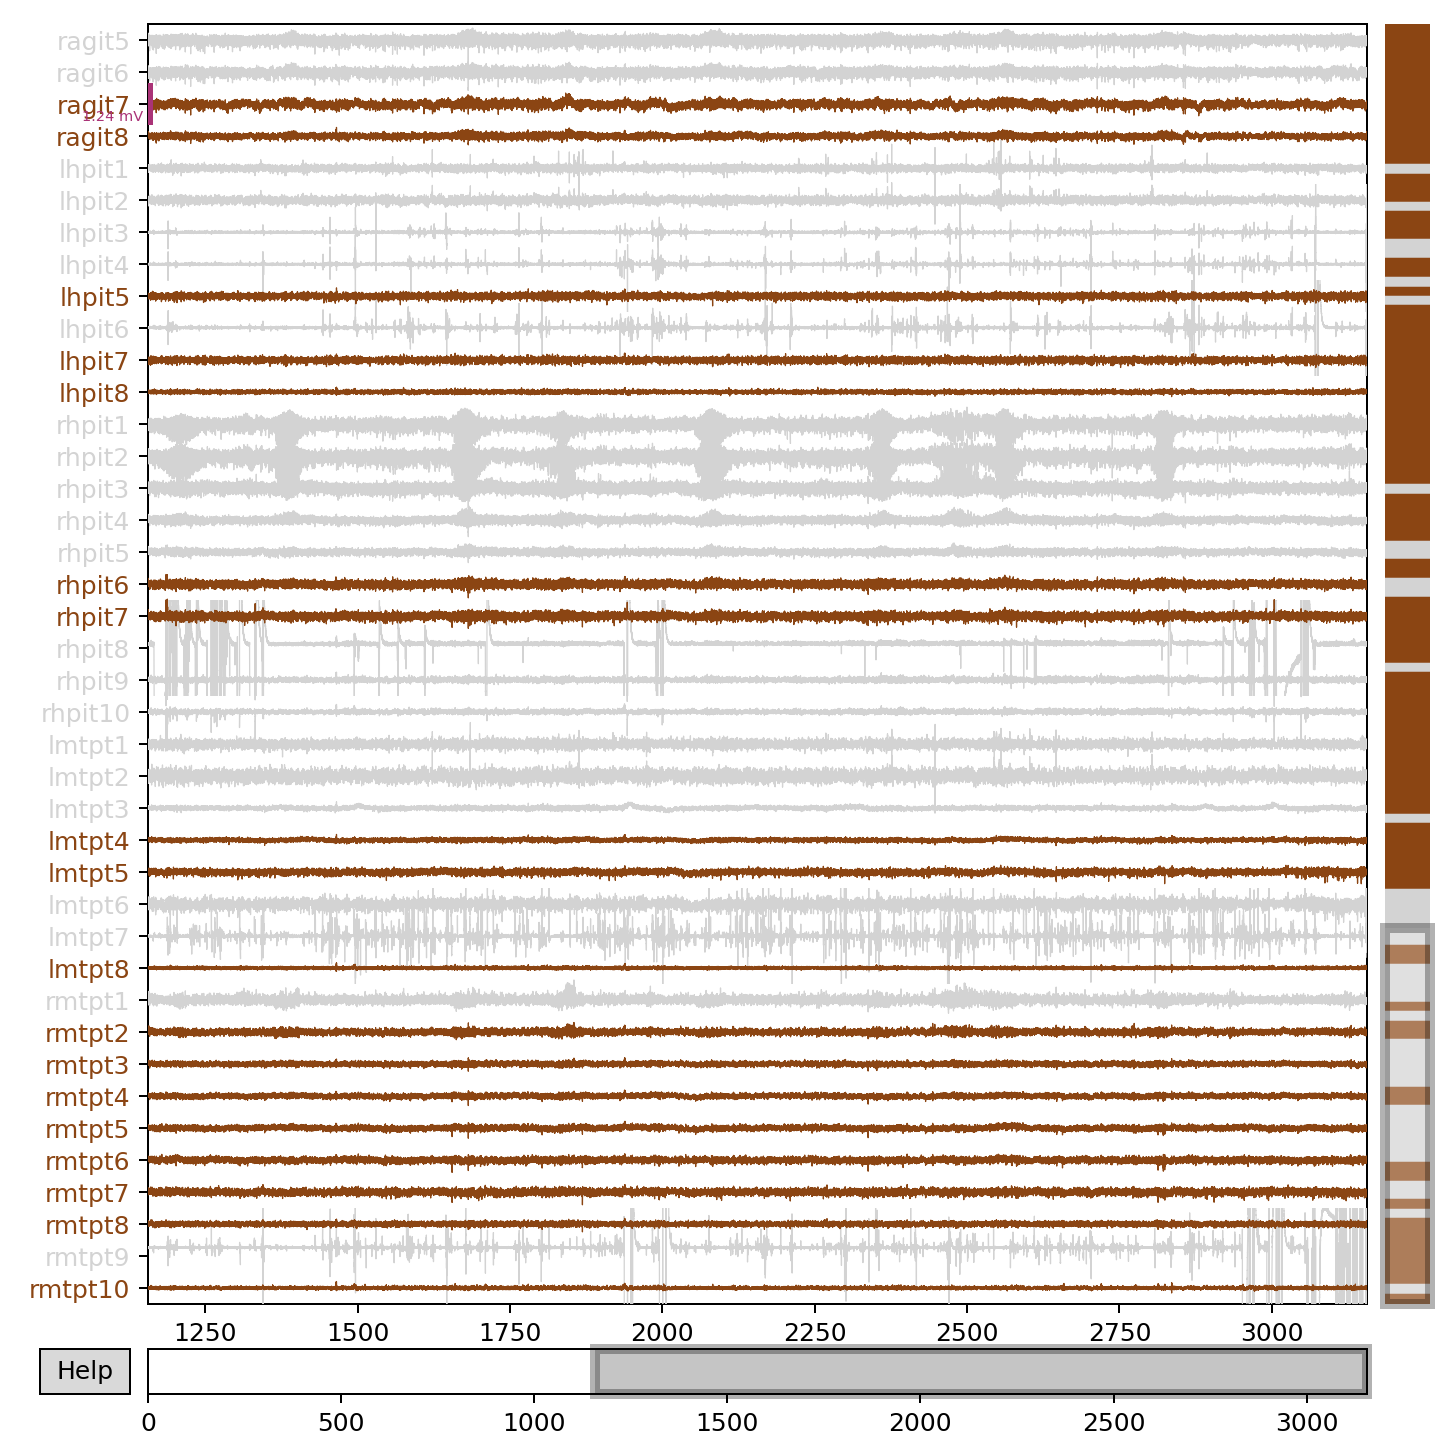

In [8]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=2000, n_channels=40, scalings=mne_data._data.max()/20)
# fig.fake_keypress('a')

In [9]:
mne_data.info['bads']

['rmolf10',
 'lacas2',
 'lacas3',
 'lacas6',
 'rmcps9',
 'rmcps4',
 'rmcps5',
 'rmcps8',
 'ragit1',
 'lhpit3',
 'lhpit4',
 'lhpit6',
 'ragit2',
 'ragit3',
 'rhpit1',
 'rhpit2',
 'rhpit8',
 'lmtpt7',
 'rmtpt1',
 'rmtpt9',
 'rhpit4',
 'lasenc7',
 'ragit4',
 'ragit5',
 'ragit6',
 'rhpit5',
 'lmtpt6',
 'rhpit3',
 'rhpit10',
 'rhpit9',
 'lacas8',
 'lmcps8',
 'lhpit1',
 'lhpit2',
 'lagit1',
 'lmtpt1',
 'lmtpt2',
 'lmtpt3',
 'rmolf6']

In [10]:
mne_data.info #sanity check that bads info saved

<Info | 12 non-empty values
 bads: 39 items (rmolf10, lacas2, lacas3, lacas6, rmcps9, rmcps4, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 136 sEEG
 custom_ref_applied: False
 dig: 136 items (136 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 16:04:18 UTC
 meas_id: 4 items (dict)
 nchan: 136
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [11]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [12]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=15, n_times=1578125
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Added the following bipolar channels:
lacas1-lacas4, lagit4-lagit5, lagit5-lagit6, lagit6-lagit7, lasenc1-lasenc2, lhpit5-lhpit7, lhpit7-lhpit8, lmcps2-lmcps3, lmolf6-lmolf7, lmolf7-lmolf8, lmtpt4-lmtpt5, lmtpt5-lmtpt8, rins3-rins4, rins4-rins5, rmtpt7-rmtpt8


In [16]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 15 x 1578125 (3156.2 s), ~180.7 MB, data loaded>

In [17]:
mne_data_bp_reref.ch_names

['lacas1-lacas4',
 'lagit4-lagit5',
 'lagit5-lagit6',
 'lagit6-lagit7',
 'lasenc1-lasenc2',
 'lhpit5-lhpit7',
 'lhpit7-lhpit8',
 'lmcps2-lmcps3',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmtpt4-lmtpt5',
 'lmtpt5-lmtpt8',
 'rins3-rins4',
 'rins4-rins5',
 'rmtpt7-rmtpt8']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


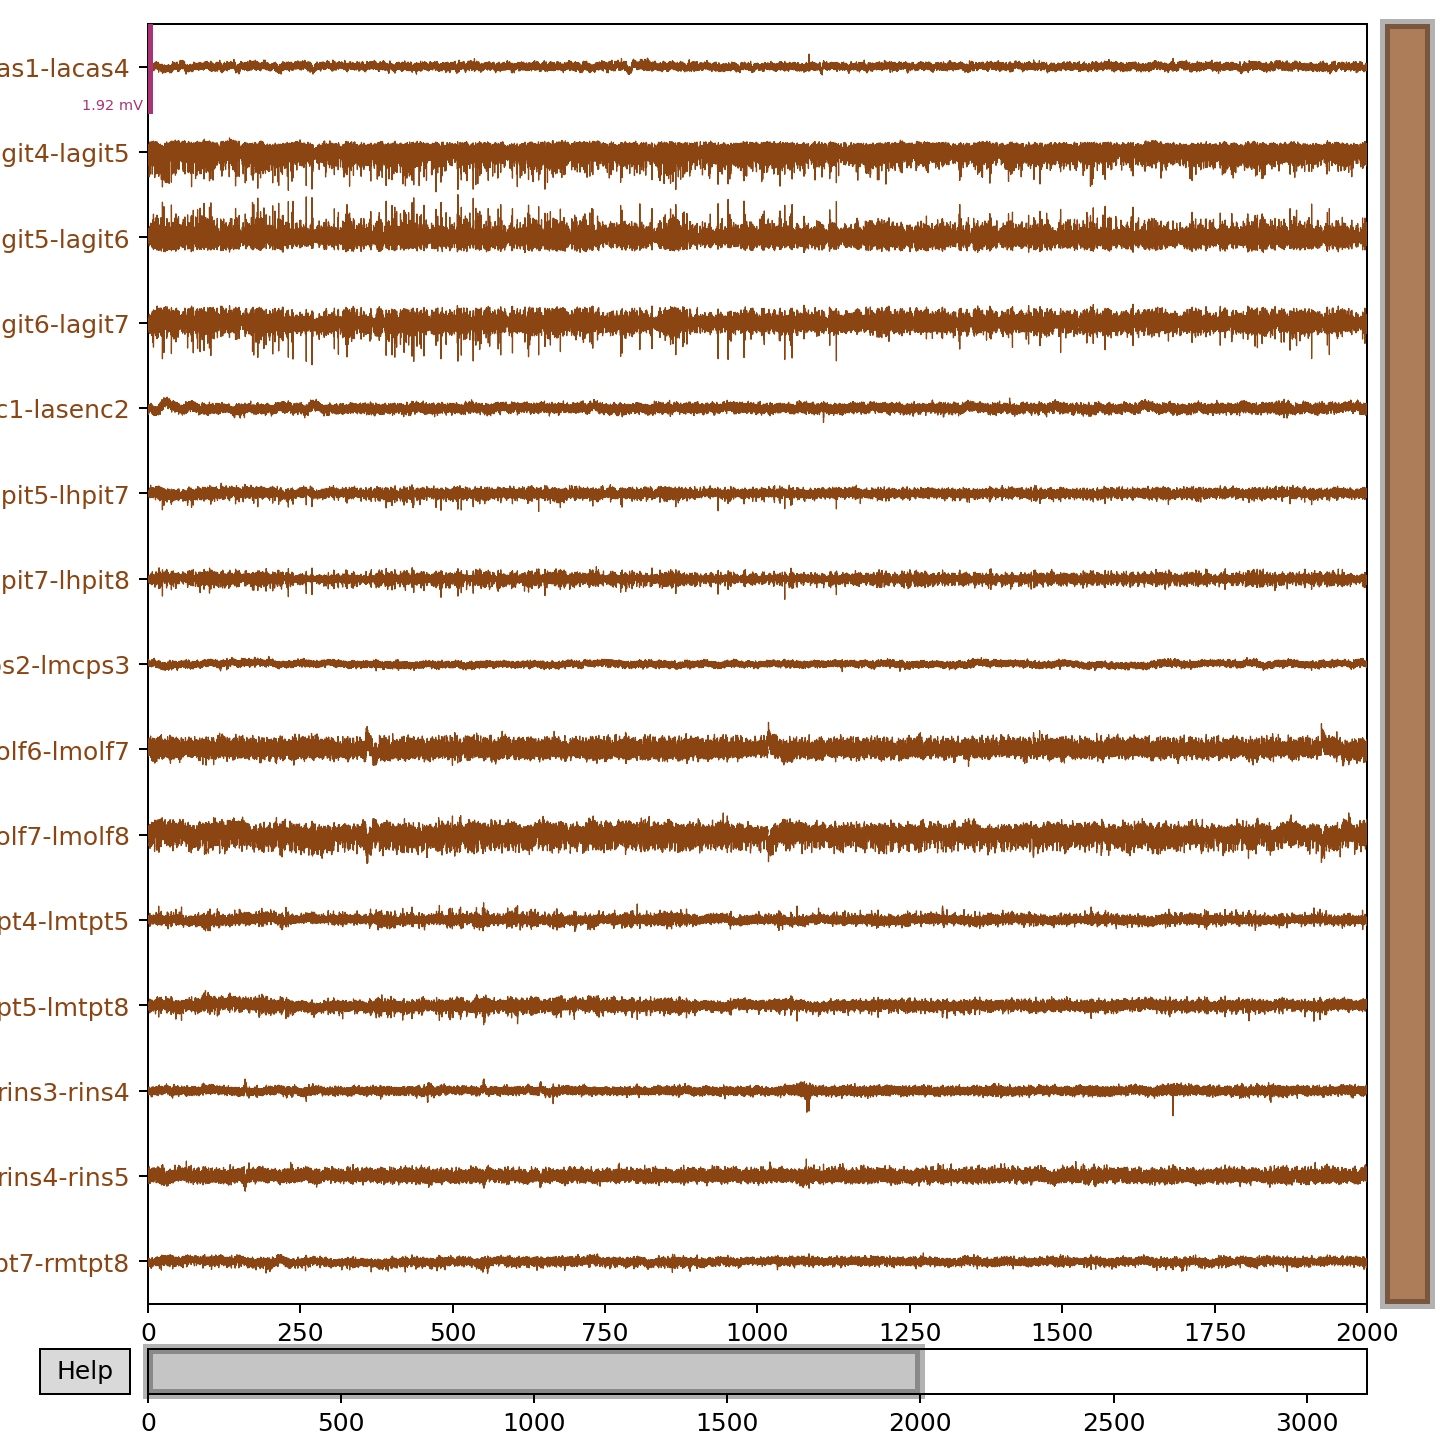

In [18]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=2000, n_channels=20, scalings=mne_data_bp_reref._data.max())
# fig.fake_keypress('a')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<IPython.core.display.Javascript object>


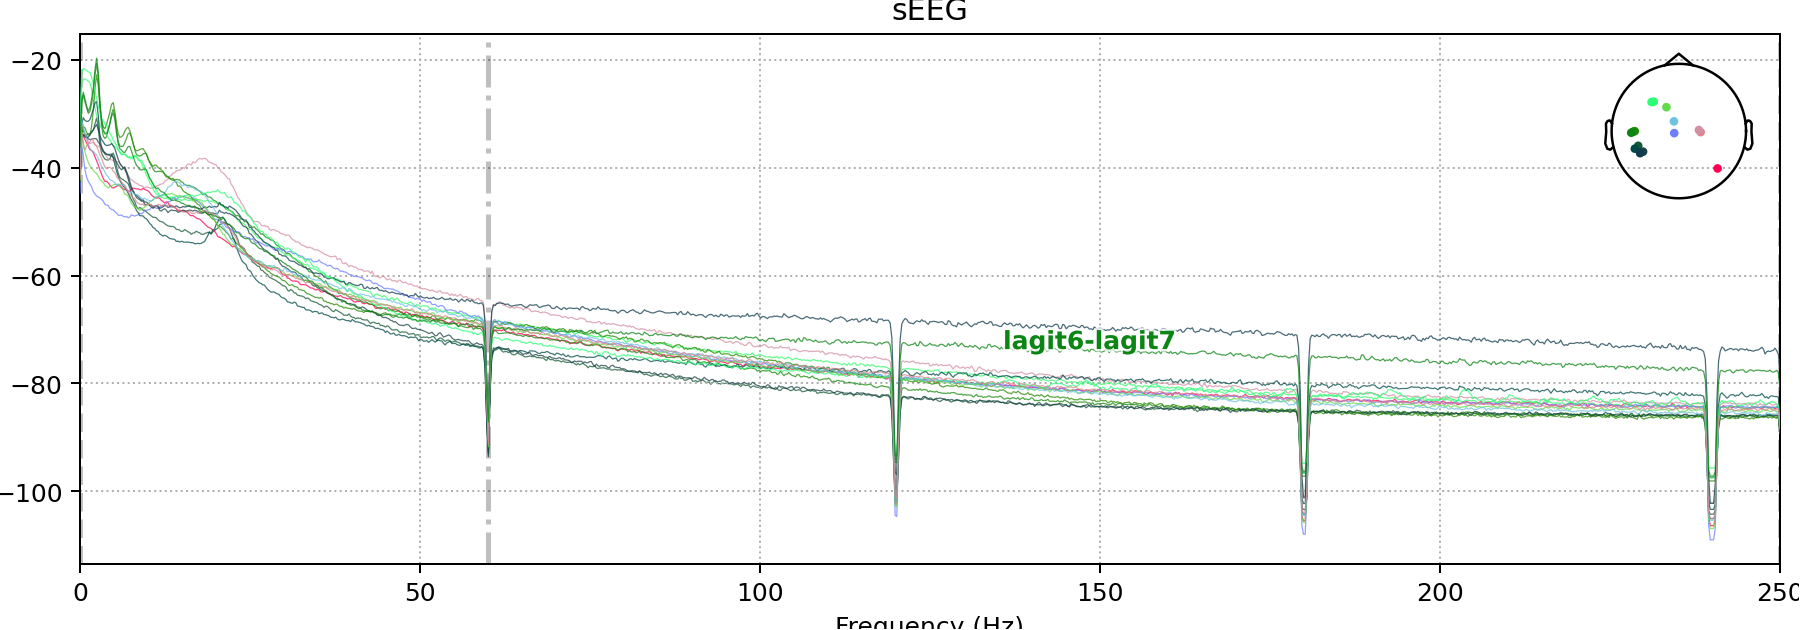

<IPython.core.display.Javascript object>


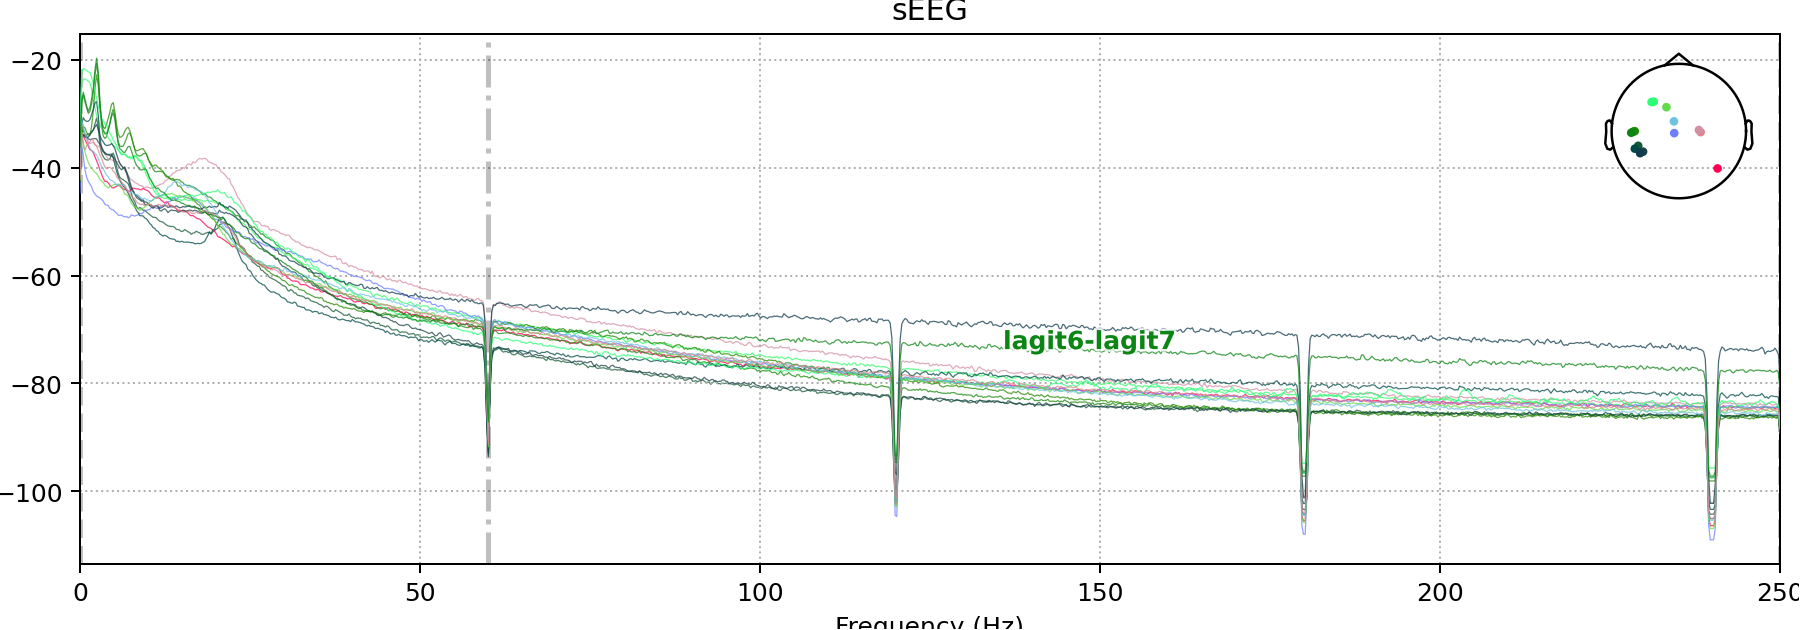

In [19]:
mne_data_bp_reref.plot_psd()

In [20]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif
[done]


## Save mne_data

In [21]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [22]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [23]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/photodiode.fif...
Isotrak not found
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Reading 0 ... 1578124  =      0.000 ...  3156.248 secs...


In [24]:
photodiode_data

<Raw | photodiode.fif, 1 x 1578125 (3156.2 s), ~12.0 MB, data loaded>

In [25]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.1

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

19 blocks
...................

found matches for 90 of 290 pulses
14 blocks
..............

found matches for 60 of 290 pulses


In [26]:
print(slope, offset,smoothSize,windSize,height)

0.999994782231763 -90.83755036990078 11 15 0.1


In [27]:
[(x*slope + offset) for x in beh_ts]

[1060.7359894548922,
 1072.716485243128,
 1084.3755874083215,
 1098.26192495223,
 1106.2691160723548,
 1117.332449346148,
 1130.8280860286716,
 1140.6878314825476,
 1153.0423008194357,
 1166.3912648672829,
 1175.9420454332592,
 1187.2026842775442,
 1201.489581631437,
 1213.2748295384258,
 1223.0097778434651,
 1238.187057551517,
 1247.4974684717013,
 1258.7701894529464,
 1272.1857524532797,
 1284.78237822668,
 1294.1654103679166,
 1308.299023021635,
 1318.18949501516,
 1329.700250754384,
 1342.879710786671,
 1354.494906480948,
 1364.9662188437728,
 1378.7277891387414,
 1390.6997167716634,
 1399.6028030171633,
 1423.0492217785586,
 1430.7960457572049,
 1442.4281372633377,
 1454.4998343756836,
 1465.4271359592788,
 1479.2745943060772,
 1501.62281919759,
 1537.1586331789986,
 1547.2517436151966,
 1565.611466917921,
 1578.0354997918741,
 1588.6999817467683,
 1609.105254176233,
 1622.5355480997061,
 1632.919417618791,
 1652.1153005586132,
 1662.0841169433677,
 1672.6829787406714,
 1690.97746

In [166]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [28]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [29]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [30]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [31]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif...
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Reading 0 ... 1578124  =      0.000 ...  3156.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concu

Used Annotations descriptions: ['TrialOnset']
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 15 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_ref_ieeg.fif...
    Range : 0 ... 1578124 =      0.000 ...  3156.248 secs
Ready.
Reading 0 ... 1578124  =      0.000 ...  3156.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 15 columns


In [33]:
epochs_all_evs 


{'TrialOnset': <Epochs |  145 events (all good), -2 - 1 sec, baseline off, ~25.0 MB, data loaded, with metadata,
  'TrialOnset': 145>,
 'DecisionOnset': <Epochs |  145 events (all good), -1 - 6 sec, baseline off, ~58.2 MB, data loaded, with metadata,
  'DecisionOnset': 145>}

### Add behavioral data to metadata 

In [34]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [35]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [36]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 73 columns
Replacing existing metadata with 73 columns


In [37]:
epochs_all_evs[event].metadata

lacas1-lacas4 lagit4-lagit5 lagit5-lagit6 lagit6-lagit7 lasenc1-lasenc2  \
0             NaN           NaN           NaN           NaN             NaN   
1             NaN           NaN           NaN           NaN             NaN   
2             NaN           NaN           NaN           NaN             NaN   
3             NaN           NaN           NaN           NaN             NaN   
4             NaN           NaN           NaN           NaN             NaN   
..            ...           ...           ...           ...             ...   
140           NaN         noise           NaN           NaN             NaN   
141           NaN           NaN           NaN           NaN             NaN   
142           NaN           NaN           NaN           NaN             NaN   
143           NaN           NaN           NaN           NaN             NaN   
144           NaN           NaN           NaN           NaN             NaN   

    lhpit5-lhpit7 lhpit7-lhpit8 lmcps2-lmcps3 lmolf6-lmolf7 lmolf7-lmolf8  \
0             NaN           NaN           NaN           NaN           NaN   
1             NaN           NaN           NaN           NaN           NaN   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
140           NaN           NaN           NaN           NaN           NaN   
141           NaN           NaN           NaN           NaN           NaN   
142           NaN           NaN           NaN         noise           NaN   
143           NaN           NaN           NaN           NaN           NaN   
144           NaN           NaN           NaN           NaN           NaN   

     ... util_dCPE_emmap util_tCF_emmap util_dCF_emmap util_tRegret_emmap  \
0    ...       -0.413519       0.895477       0.413519          -0.895477   
1    ...        0.437196      -0.641336       0.000000           0.000000   
2    ...       -0.521639       1.333693       0.521639          -1.333693   
3    ...        0.007368       0.000000       0.128685           0.000000   
4    ...        0.026868      -0.380390      -0.380390           0.000000   
..   ...             ...            ...            ...                ...   
140  ...       -0.026607       0.026607       0.026607          -0.026607   
141  ...       -0.122523       0.085499       0.000000          -0.208022   
142  ...       -0.244321       0.244321       0.244321          -0.244321   
143  ...       -0.215708       0.400409       0.215708          -0.400409   
144  ...        0.148860       0.000000       0.128685           0.000000   

    util_dRegret_emmap util_tRelief_emmap  util_dRelief_emmap  util_RPE_emmap  \
0            -0.413519           0.000000            0.000000       -0.895477   
1             0.000000           1.078532            0.437196        0.641336   
2            -0.521639           0.000000            0.000000       -1.333693   
3             0.000000           0.136054            0.007368        0.000000   
4             0.000000           0.026868            0.026868        0.000000   
..                 ...                ...                 ...             ...   
140          -0.026607           0.000000            0.000000        0.000000   
141          -0.122523           0.000000            0.000000       -0.085499   
142          -0.244321           0.000000            0.000000        0.000000   
143          -0.215708           0.000000            0.000000       -0.400409   
144           0.000000           0.277546            0.148860        0.000000   

     util_pRPE_emmap util_nRPE_emmap  
0           0.000000       -0.895477  
1           0.641336        0.000000  
2           0.000000       -1.333693  
3           0.000000        0.000000  
4           0.000000        0.000000 

### Save raw epoched data 

In [38]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [39]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [40]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [41]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [42]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [43]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 145, channels : 15, ~249.5 MB>}

In [44]:
power_epochs = {}

In [45]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 73 columns


In [46]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 145, channels : 15, ~1.22 GB>

In [47]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [48]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01252024


In [7]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

-90.83755036990078


<IPython.core.display.Javascript object>


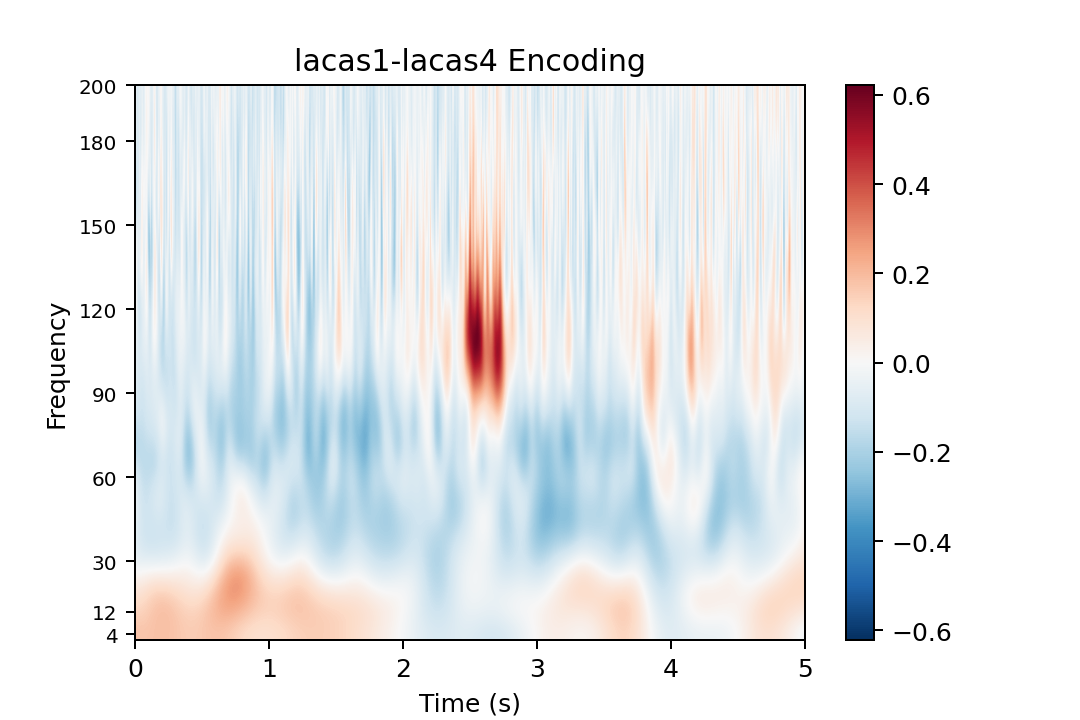

<IPython.core.display.Javascript object>


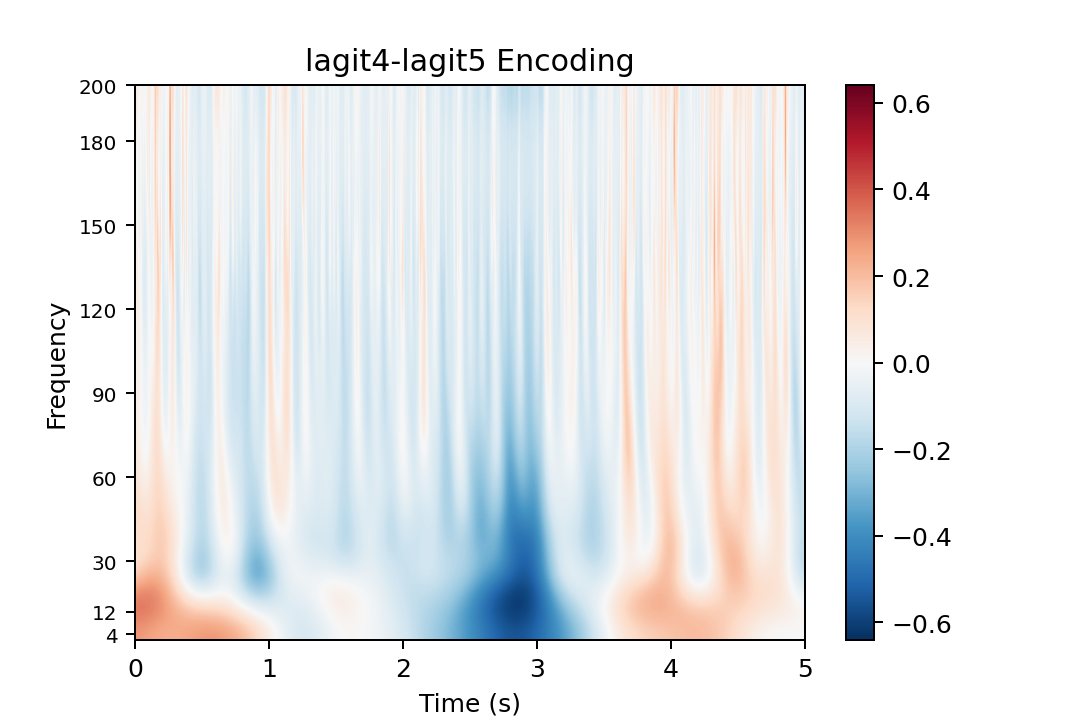

<IPython.core.display.Javascript object>


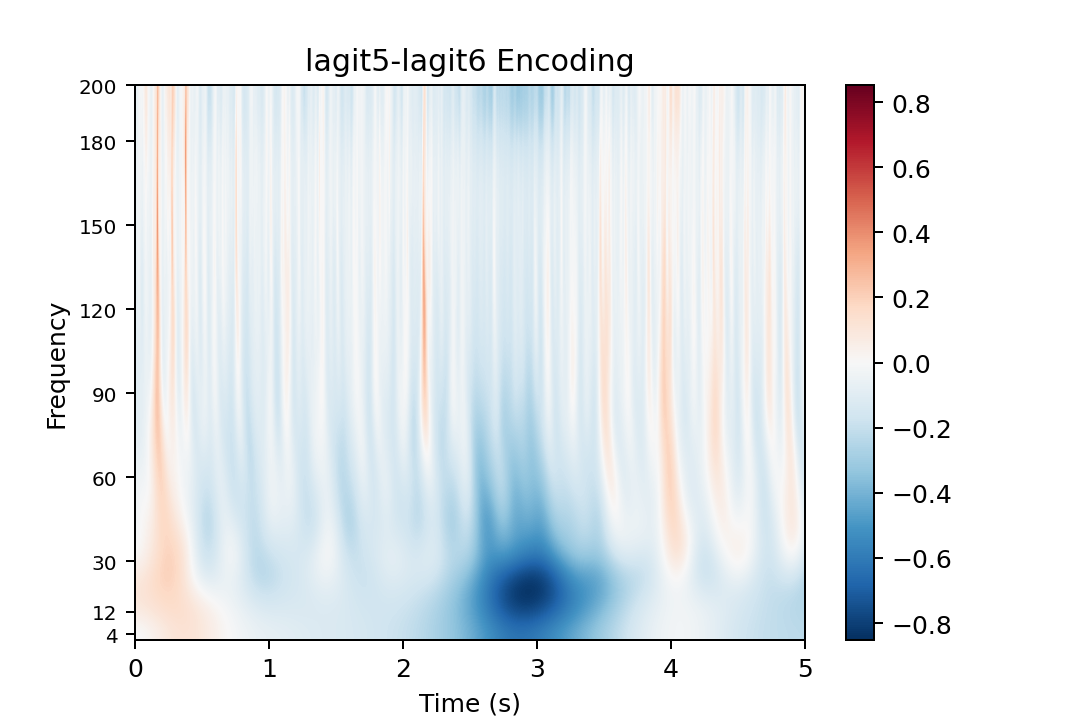

<IPython.core.display.Javascript object>


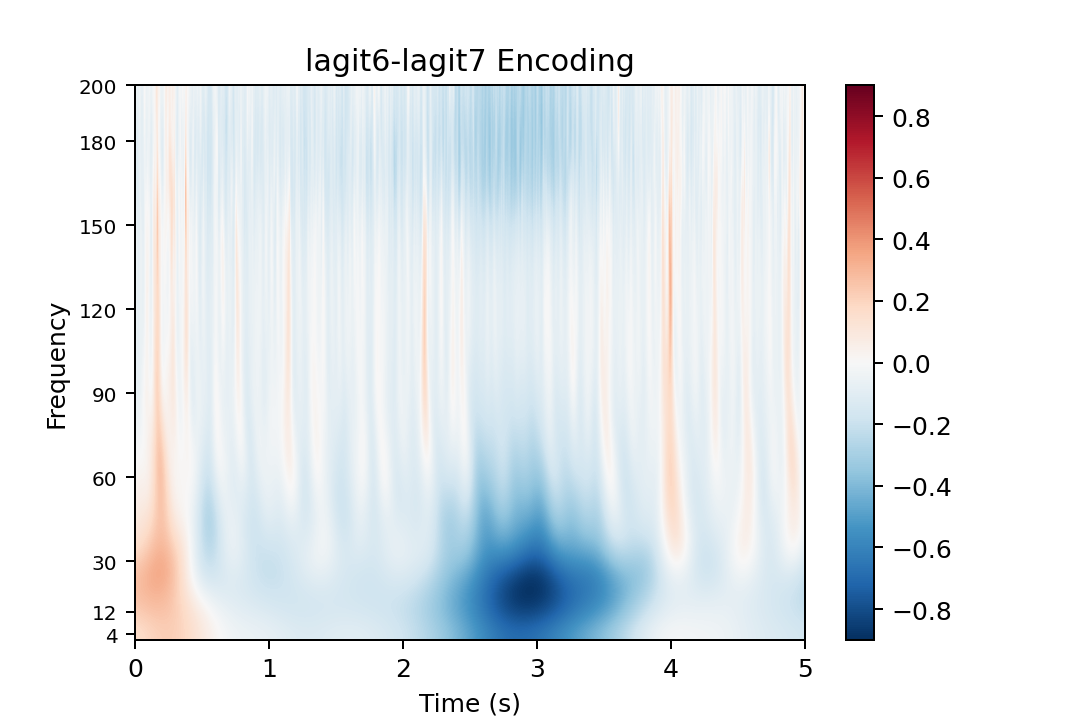

<IPython.core.display.Javascript object>


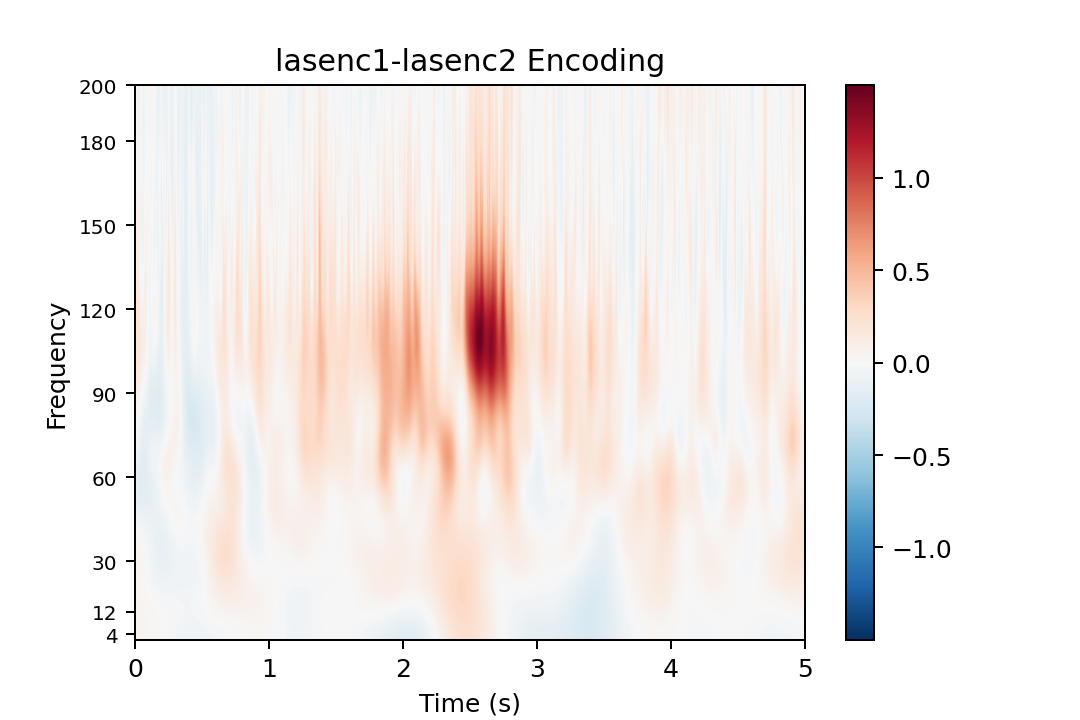

<IPython.core.display.Javascript object>


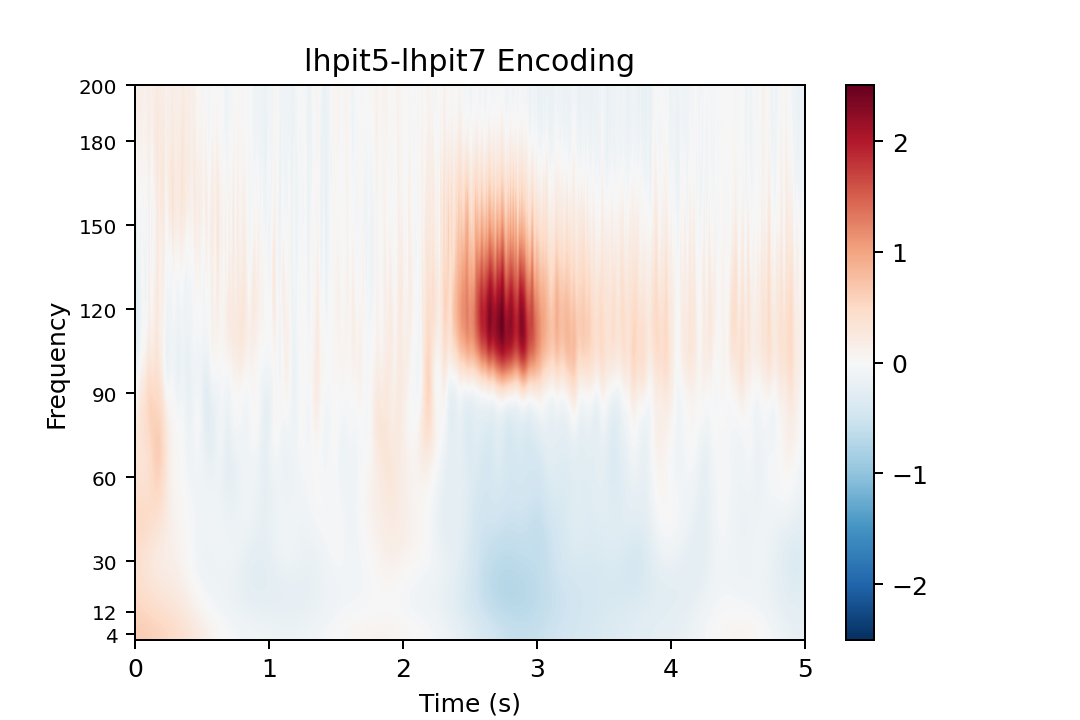

<IPython.core.display.Javascript object>


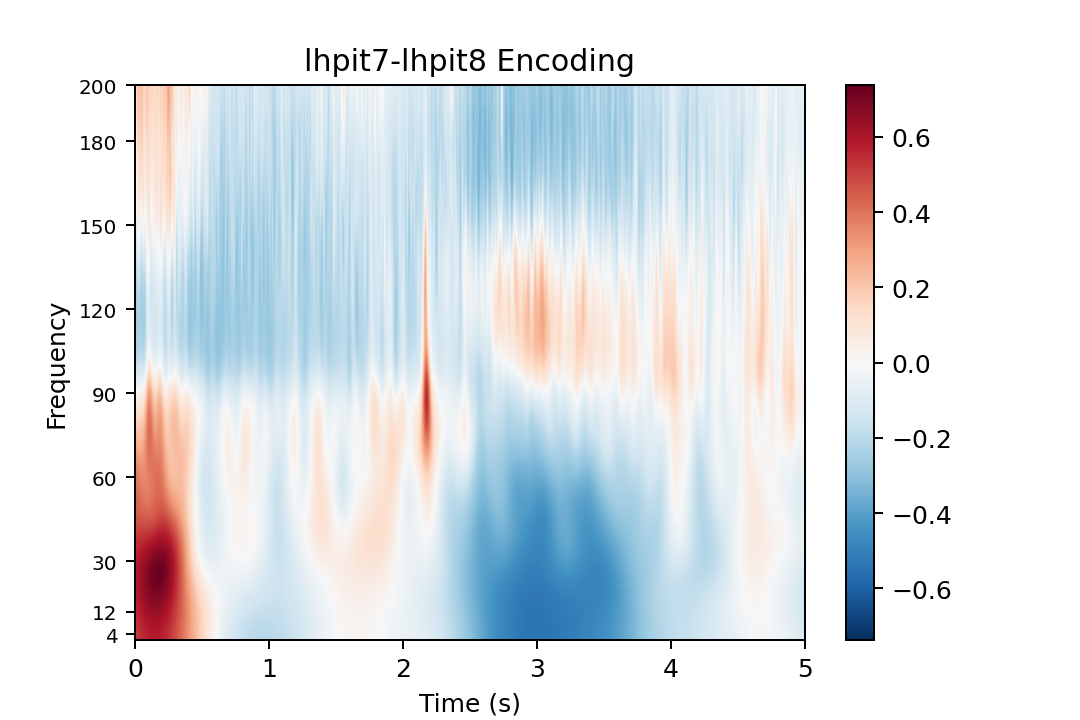

<IPython.core.display.Javascript object>


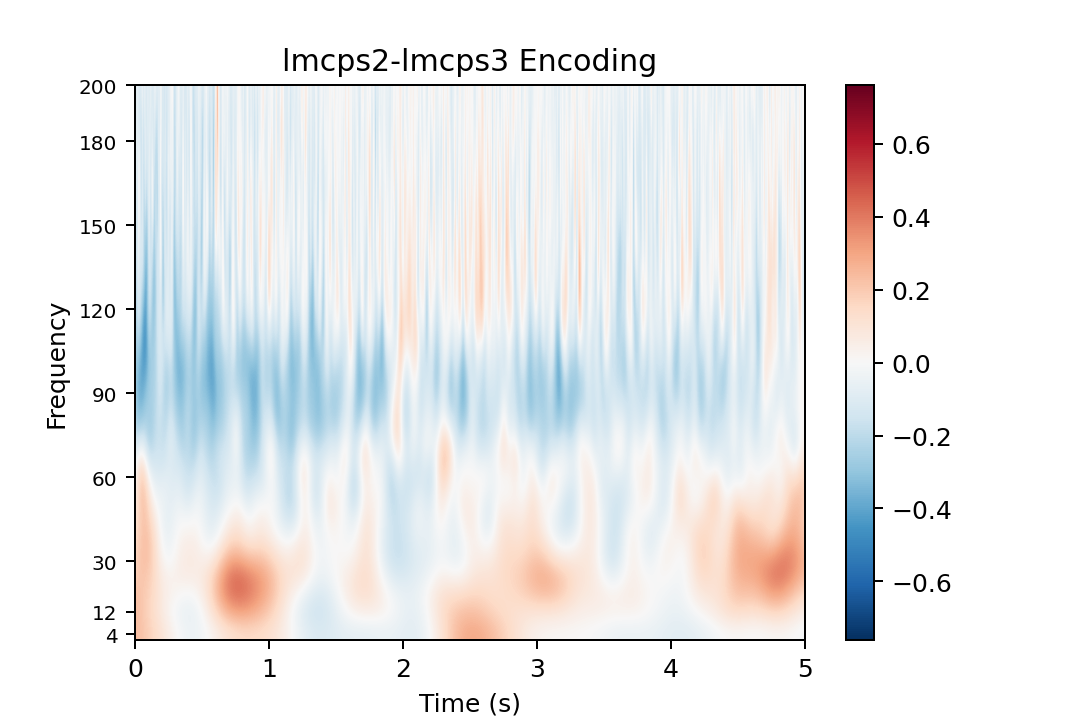

<IPython.core.display.Javascript object>


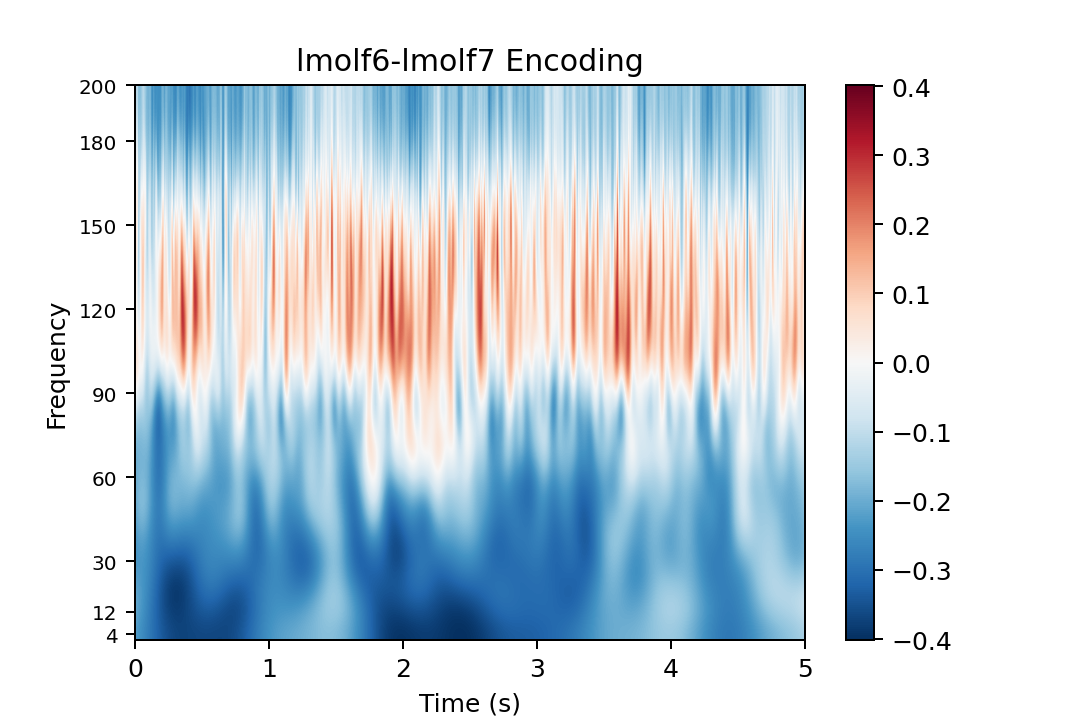

<IPython.core.display.Javascript object>


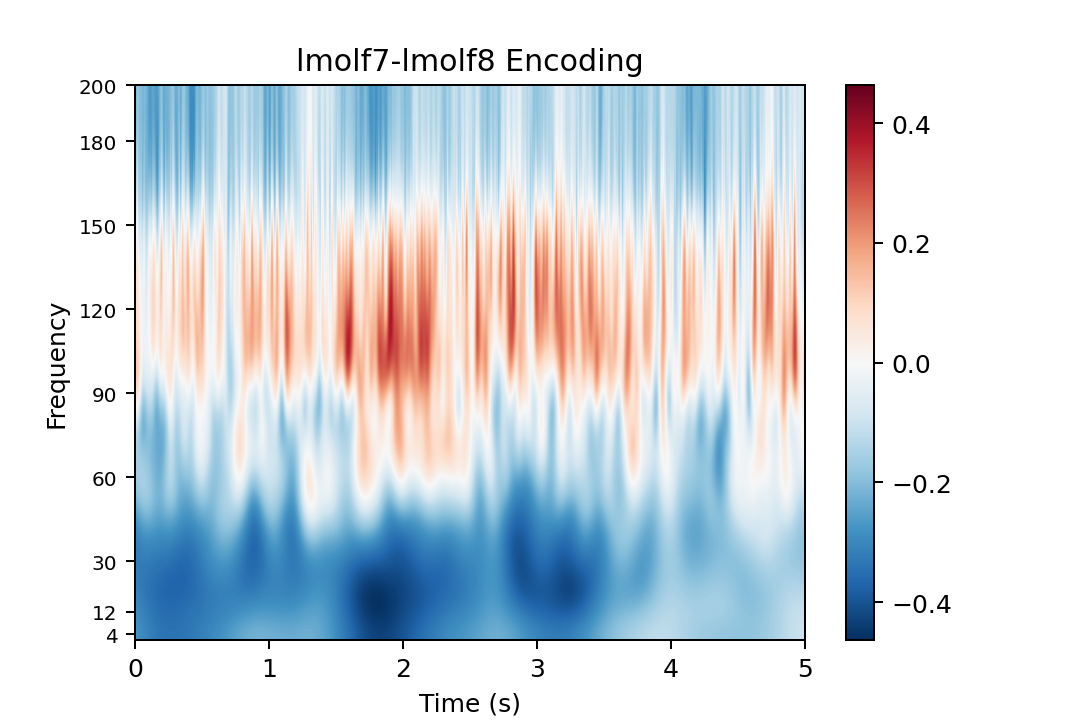

<IPython.core.display.Javascript object>


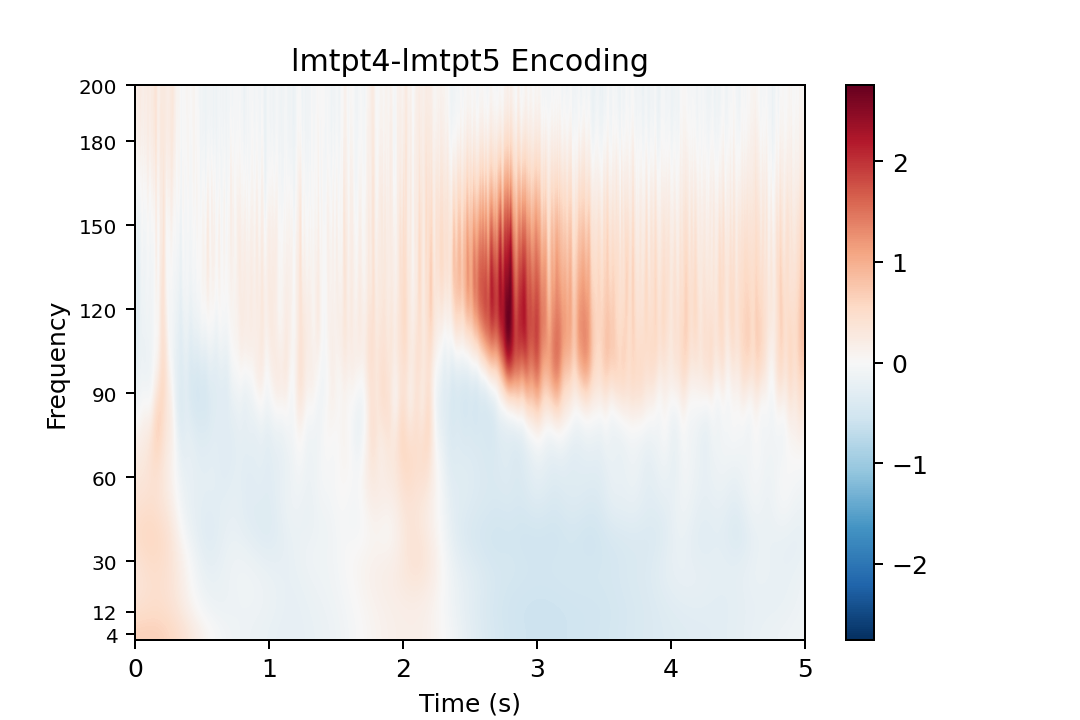

<IPython.core.display.Javascript object>


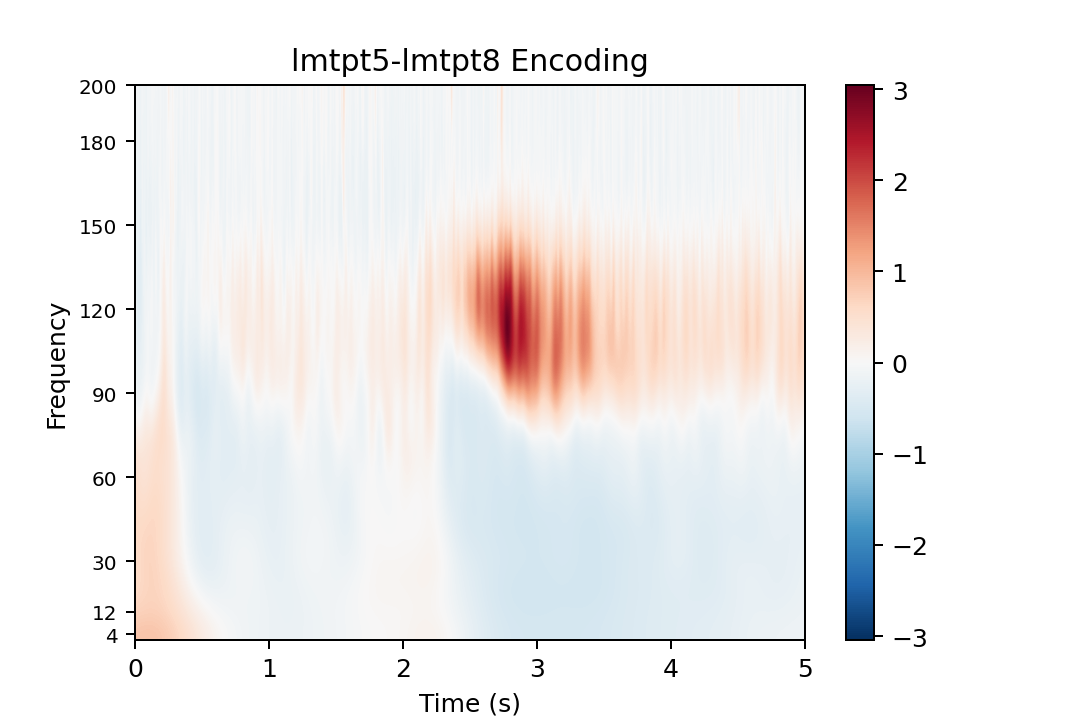

<IPython.core.display.Javascript object>


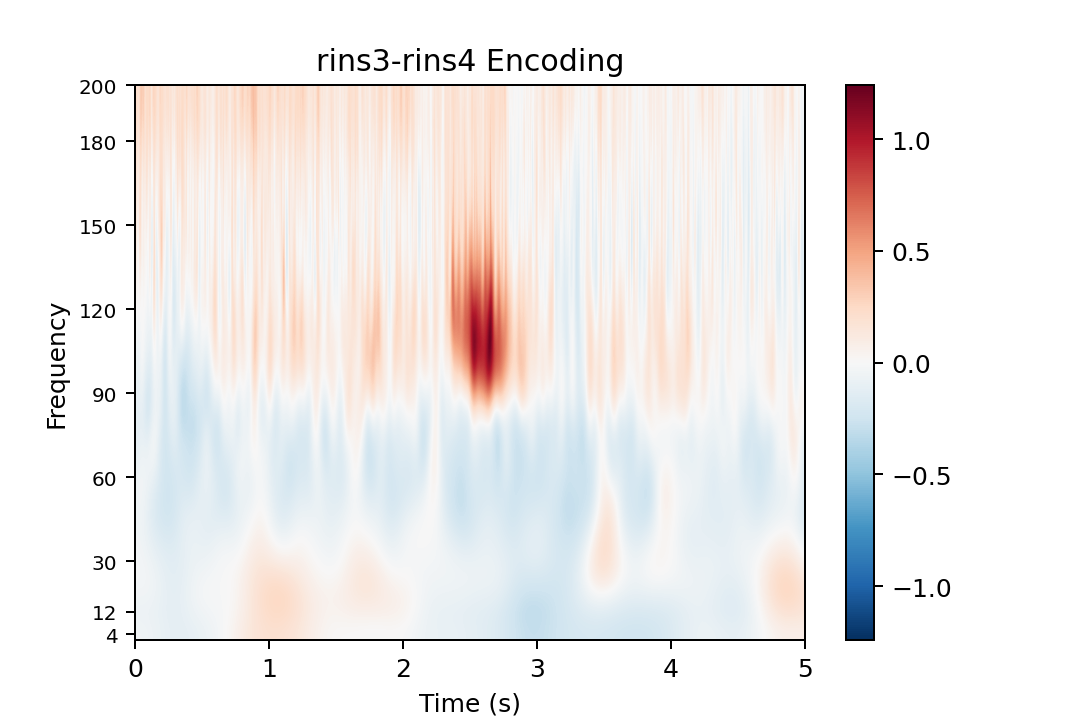

<IPython.core.display.Javascript object>


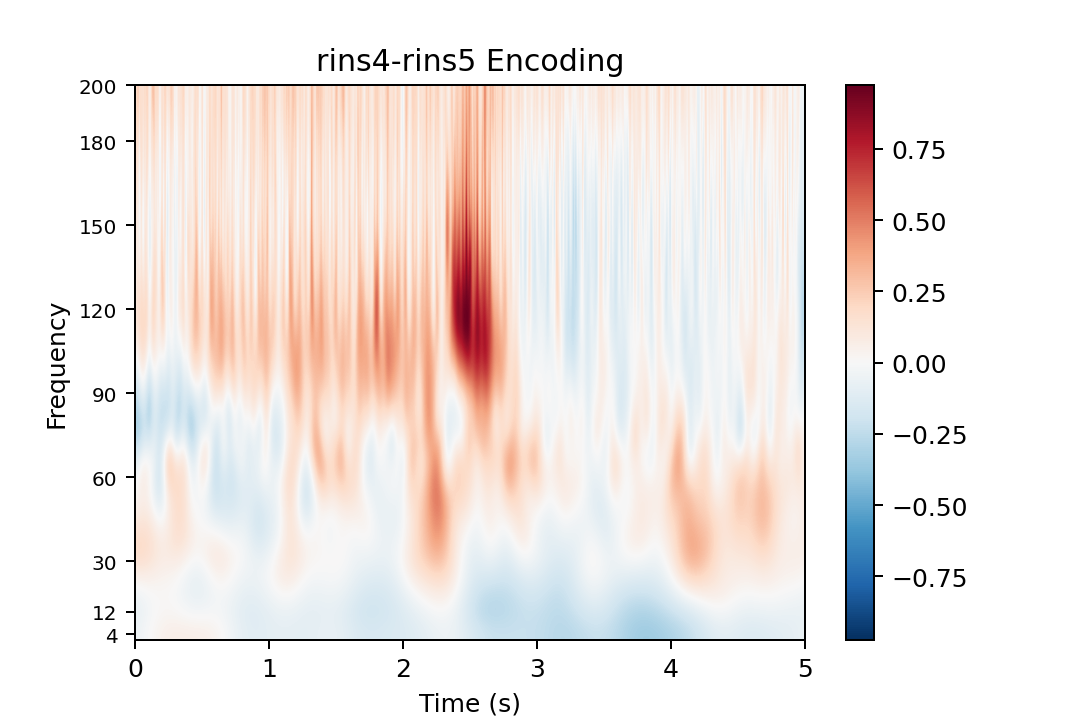

<IPython.core.display.Javascript object>


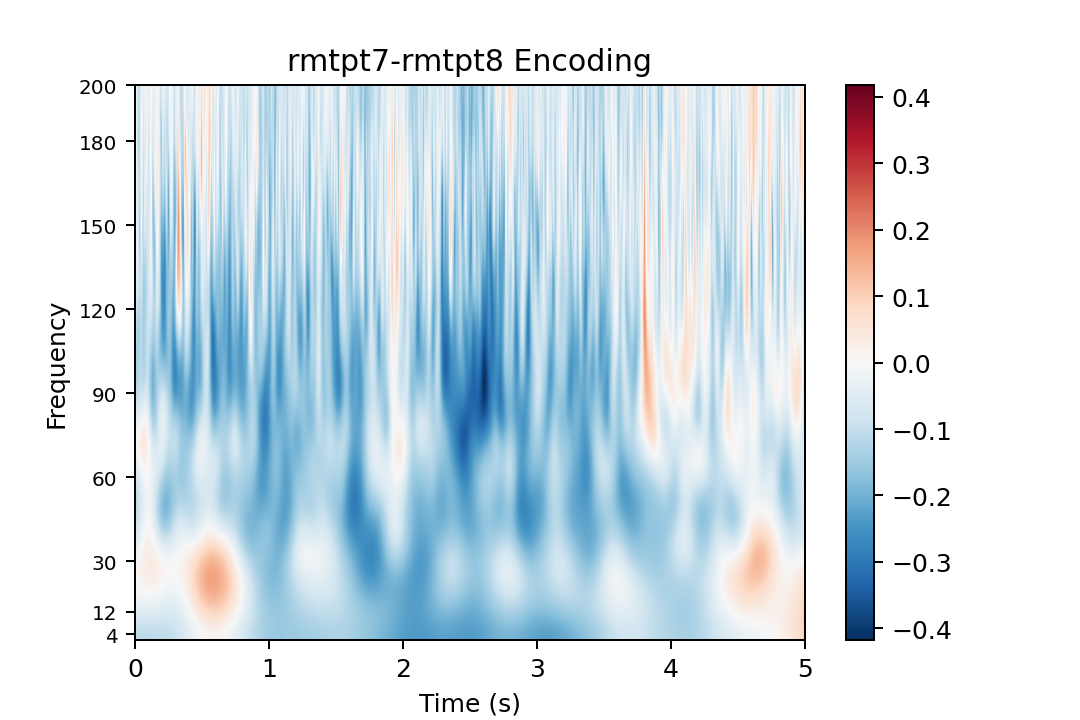

In [49]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
